In [108]:
import joblib
import matplotlib.pyplot as plt
import mplcyberpunk
import pandas as pd
import yaml
from sklearn.base import BaseEstimator
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Import

In [109]:
config_path = "../config/params.yml"
config = yaml.load(open(config_path), Loader=yaml.FullLoader)
preproc = config["preprocessing"]

In [110]:
baseline = joblib.load(config["train"]["baseline_model_path"])
tuned_model = joblib.load(config["train"]["tuned_model_path"])

In [111]:
X_test = pd.read_parquet(preproc["test_data_path"])
weeks_test = X_test.pop("WEEK_NUM")
y_test = X_test.pop("target")
X_test

,days30_165L,maritalst_385M,pmtscount_423L,requesttype_4525192L,annuity_780A,annuitynextmonth_57A,avginstallast24m_3658937A,avgoutstandbalancel6m_4187114A,cntincpaycont9m_3716944L,cntpmts24_3658933L,...,purposeofcred_active,residualamount_closed,subjectrole_active,subjectrole_closed,empladdr,num_total_inst,num_total_paid_inst,cred_closure_date_days_ago,actualdpd,sellerplace_cnt
case_id,,,,,,,,,,,,,,,,,,,,,
1363221.0,0.0,2.0,NaN,None,2905.0000,7087.0,5636.4000,146023.800,5.0,20.0,...,a55475b1,NaN,a55475b1,a55475b1,a55475b1,50.0,52.0,NaN,0.0,0
1670326.0,2.0,3.0,NaN,DEDUCTION_6,9231.8000,6243.0,5222.4000,116782.664,16.0,20.0,...,a55475b1,0.0,a55475b1,a55475b1,a55475b1,39.0,41.0,-42.0,0.0,3
253536.0,1.0,0.0,NaN,None,2485.2000,0.0,3293.4001,NaN,0.0,12.0,...,a55475b1,NaN,a55475b1,a55475b1,a55475b1,32.0,33.0,-88.0,0.0,6
615071.0,NaN,2.0,NaN,None,5816.8003,0.0,NaN,NaN,NaN,NaN,...,None,NaN,None,None,a55475b1,0.0,NaN,NaN,0.0,1
1894843.0,0.0,0.0,NaN,None,2585.2000,5428.2,6443.2000,153940.050,14.0,23.0,...,a55475b1,NaN,a55475b1,a55475b1,a55475b1,140.0,97.0,-437.0,0.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
751416.0,2.0,3.0,7.0,None,1800.0000,0.0,NaN,NaN,NaN,NaN,...,60c73645,0.0,a55475b1,a55475b1,P46_103_143,0.0,NaN,-1533.0,0.0,1
622194.0,0.0,2.0,0.0,None,2545.4001,0.0,NaN,NaN,NaN,NaN,...,a55475b1,NaN,a55475b1,a55475b1,P62_116_179,0.0,NaN,NaN,0.0,1
11340.0,0.0,0.0,7.0,None,3175.8000,0.0,NaN,NaN,NaN,NaN,...,a55475b1,NaN,a55475b1,a55475b1,P6_35_77,0.0,NaN,NaN,0.0,0


# Finance

In [116]:
y_pred_baseline = baseline.predict(X_test)
cm_baseline = confusion_matrix(y_test, y_pred_baseline)

y_pred_tuned = tuned_model.predict(X_test)
cm_tuned = confusion_matrix(y_test, y_pred_tuned)

In [118]:
def confusion_plot(
    cm_baseline: np.ndarray,
    cm_tuned: np.ndarray,
    dark_mode: bool = False,
) -> str:
    """Force plot

    Parameters
    ----------
    cm_baseline: np.ndarray
        confusion matrix for baseline model
    cm_tuned: np.ndarray
        confusion matrix for tuned model
    dark_mode: bool, default = True
        Use dark theme
    """
    if dark_mode:
        plt.style.use("cyberpunk")
    else:
        plt.rcdefaults()
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    disp_b = ConfusionMatrixDisplay(cm_baseline)
    disp_t = ConfusionMatrixDisplay(cm_tuned)
    disp_b.plot(ax=ax[0])
    disp_t.plot(ax=ax[1])
    ax[0].title.set_text("Confusion Matrix CatBoost Baseline")
    ax[1].title.set_text("Confusion Matrix CatBoost Tuned")
    if dark_mode:
        ax[0].xaxis.set_major_locator(plt.NullLocator())
        ax[0].yaxis.set_major_locator(plt.NullLocator())
        ax[1].xaxis.set_major_locator(plt.NullLocator())
        ax[1].yaxis.set_major_locator(plt.NullLocator())
    plt.tight_layout()
    return fig

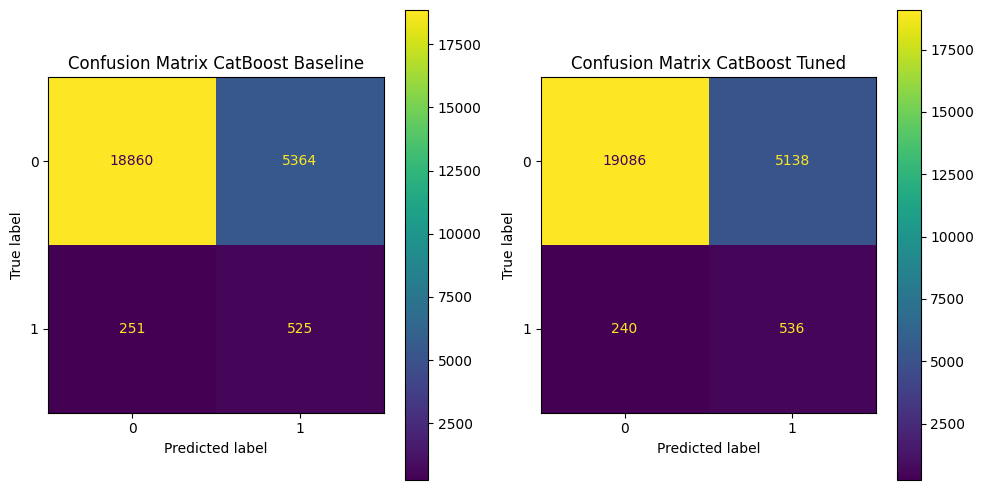

In [119]:
plt.ioff()
confusion_plot(cm_baseline, cm_tuned)

In [17]:
def finance(
    model: BaseEstimator, credamount: pd.Series, y_true: pd.Series, X: pd.DataFrame
) -> tuple:
    """Estimate saved and lost money using current model.

    Returns amount of saved_money as tp_sum + tn_sum,
    amount of lost money as fp_sum + fn_sum
    and percent as lost_money / maximal possible saved money amount

    Parameters
    ----------
    model: BaseEstimator

    credamount: pd.Series
        With values of credit price.

    y_true: array-like of shape (n_samples,)
        True labels.

    X: {array-like, sparse matrix, DataFrame} of shape (n_samples, n_features)
        Predict on this vectors, where `n_samples` is the number of samples and
        `n_features` is the number of features.
    Returns
    -------
    out : tuple
        saved_money, lost_money, percent
    """
    y_pred = model.predict(X)
    tp_sum = 0
    fp_sum = 0
    tn_sum = 0
    fn_sum = 0
    for i in range(credamount.shape[0]):
        amount = credamount.iloc[i]
        true_label = y_true.iloc[i]
        pred_label = y_pred[i]
        if true_label == pred_label == 1:
            tp_sum += amount
        elif true_label == pred_label == 0:
            tn_sum += amount
        elif pred_label == 1:
            fp_sum += amount
        elif pred_label == 0:
            fn_sum += amount
    saved_money = tp_sum + tn_sum
    lost_money = fp_sum + fn_sum
    max_possible_win = credamount.sum()
    percent = lost_money * 100 / max_possible_win
    return saved_money, lost_money, round(percent, 2)

In [52]:
saved_money_b, lost_money_b, percent_b = finance(
    baseline, X_test["credamount_770A"], y_test, X_test
)
saved_money_b, lost_money_b, percent_b

(962084638.9105899, 282827748.39540076, 22.72)

In [53]:
saved_money, lost_money, percent = finance(
    tuned_model, X_test["credamount_770A"], y_test, X_test
)
saved_money, lost_money, percent

(965805236.643591, 279107150.6624009, 22.42)

In [55]:
percent_delta = round(percent_b - percent, 1)
money_delta = round(saved_money - saved_money_b)
print(f"Разница в сохраненной сумме в % у моделей = {percent_delta} %")
print(f"Разница в сохраненной сумме у моделей = {money_delta}")

Разница в сохраненной сумме в % у моделей = 0.3 %
Разница в сохраненной сумме у моделей = 3720598


# Вывод

Видим что количество ложно-положительных предсказаний FP (отказали "хорошему" клиенту) намного больше количества ложно-отрицательных FN (дали кредит тому кто не вернет). Tuned Catboost модель уменьшает количество ошибок 1 и 2 рода и позволяет сохранить 3,7 млн, что на 0.3 % больше чем для Baseline модели.